### Visualizing Intermediate Representations from a model

To get a feel for what kind of features our convnet has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the convnet.

Let's pick a random image, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. 


<img src="images/ex-interpolation.png">

In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

import matplotlib.pyplot as plt
import numpy as np

print("loading the MobileNetV2 model")
baseModel = MobileNetV2(weights="imagenet", input_tensor=Input(shape=(224, 224, 3)))

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after the first layer util the layer 10
successive_outputs = [layer.output for layer in baseModel.layers[1:10]]
visualization_model = Model(inputs=baseModel.input, outputs=successive_outputs)

# The sammury of the model loaded
visualization_model.summary()

loading the MobileNetV2 model
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
bn_Conv1 (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
Conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
expanded_conv_depthwise (Dep (None, 112, 112, 32)      288       
_________________________________________________________________
expanded_conv_depthwise_BN ( 

In [16]:
# Load an image example
img = load_img("images/00-puppy.jpg", target_size=(224, 224))
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


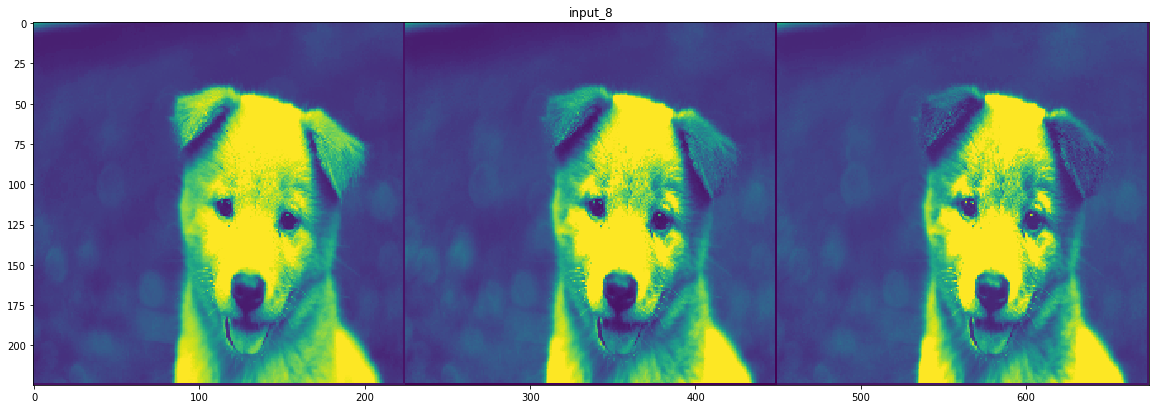

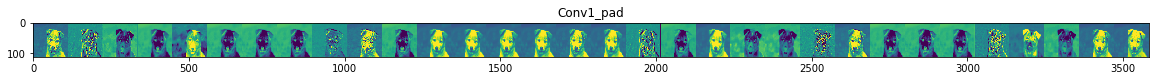

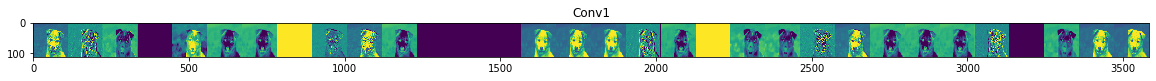

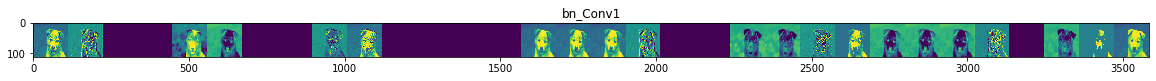

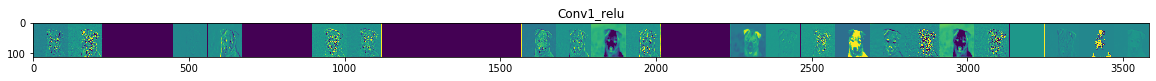

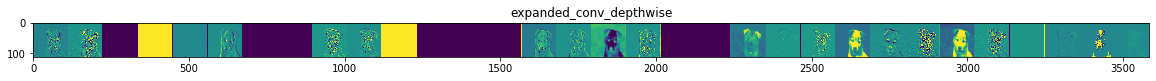

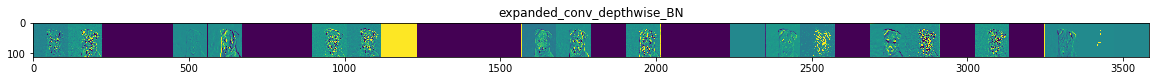

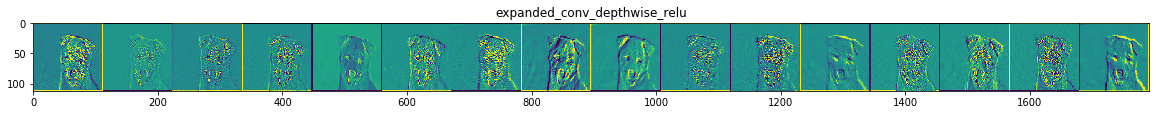

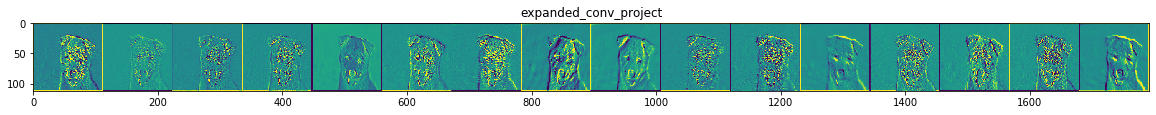

In [17]:
# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in baseModel.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
	# Just do this for the conv / maxpool layers, not the fully-connected layers
	if len(feature_map.shape) == 4:
		n_features = feature_map.shape[-1]  # number of features in feature map
		# The feature map has shape (1, size, size, n_features)
		size = feature_map.shape[1]
		# We will tile our images in this matrix
		display_grid = np.zeros((size, size * n_features))
		for i in range(n_features):
			# Postprocess the feature to make it visually palatable
			x = feature_map[0, :, :, i]
			x -= x.mean()
			x /= x.std()
			x *= 64
			x += 128
			x = np.clip(x, 0, 255).astype('uint8')
			# We'll tile each filter into this big horizontal grid
			display_grid[:, i * size : (i + 1) * size] = x
		# Display the grid
		scale = 20. / n_features
		plt.figure(figsize=(scale * n_features, scale))
		plt.title(layer_name)
		plt.grid(False)
		plt.imshow(display_grid, aspect='auto', cmap='viridis')